# Explore Dataset
1. Temporal Patterns
2. Spatial Patterns

# 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = './input/'
data = pd.read_csv(path+'training.csv')
print('N:', len(data))
print('TAZ:', len(data['geohash'].unique()))
data.head()

4206321


,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


# 1. Temporal Patterns

In [13]:
from datetime import datetime, timedelta
first_day = datetime(2018, 1, 1)  # temporary
data['date'] = data['day'].apply(lambda x: timedelta(days=x) + first_day)
data['time'] = data['timestamp'].apply(lambda x: datetime.strptime(x, '%H:%M').time())
data['datetime'] = data.apply(lambda x: pd.datetime.combine(x['date'], x['time']), axis=1)  # TODO: slow
data.head()

,geohash6,day,timestamp,demand,date,time,datetime
0,qp03wc,18,20:0,0.020072,2018-01-19,20:00:00,2018-01-19 20:00:00
1,qp03pn,10,14:30,0.024721,2018-01-11,14:30:00,2018-01-11 14:30:00
2,qp09sw,9,6:15,0.102821,2018-01-10,06:15:00,2018-01-10 06:15:00
3,qp0991,32,5:0,0.088755,2018-02-02,05:00:00,2018-02-02 05:00:00
4,qp090q,15,4:0,0.074468,2018-01-16,04:00:00,2018-01-16 04:00:00


In [46]:
counts = data['geohash6'].value_counts()
counts = dict(zip(counts.index, counts.values))
max_count = 61 * 24 * 4

## 1.1 Daily demands per TAZ

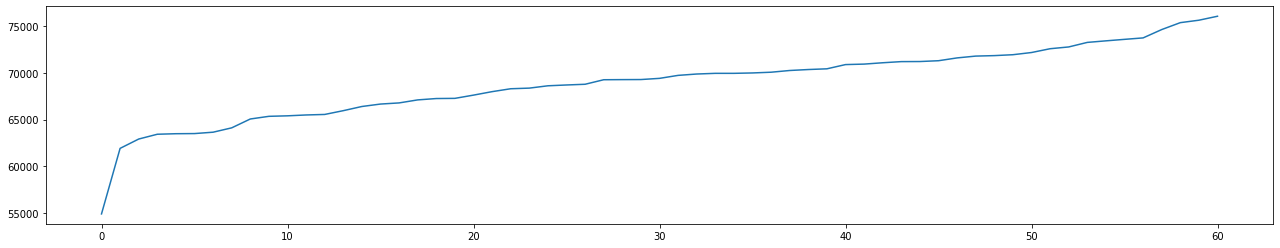

In [3]:
n_active_taz = np.sort(data['day'].value_counts())
plt.figure(figsize=(22,4))
plt.plot(n_active_taz)
plt.show()

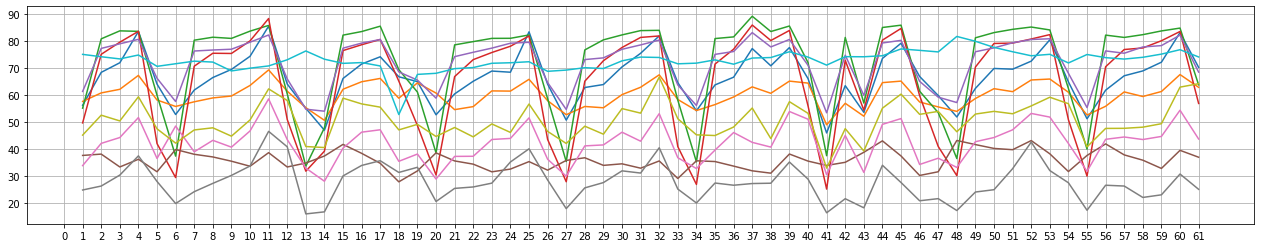

In [4]:
taz_demand = data['geohash6'].value_counts()
samples = taz_demand.index[:10]

plt.figure(figsize=(22,4))
for sample in samples:
    sample_taz = data[data['geohash6'] == sample]
    daily_demand = sample_taz.groupby(['day']).sum()
    plt.plot(daily_demand)
plt.xticks(range(62))
plt.grid()

In [47]:
taz_daily = data.groupby(['geohash6', 'day'])['demand'].sum().reset_index()
taz_daily = taz_daily.pivot(index='geohash6', columns='day', values='demand')
taz_daily.fillna(0, inplace=True)
assert sum(taz_daily.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_daily.mean(axis=1)
tazstd = taz_daily.std(axis=1)
taz_daily = taz_daily.apply(lambda x: (x - tazmean) / tazstd)
taz_daily['active_count'] = taz_daily.index.map(counts) / max_count
taz_daily.head()

day,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,-0.810720,-0.553245,-0.502718,0.408039,-0.802496,-1.007065,0.352295,-0.445095,0.938419,-0.544423,...,1.866856,-0.589964,-0.958830,0.397738,0.461034,-0.491166,4.514224,2.272901,0.909376,0.098531
qp02yf,-0.421247,-0.136156,0.290865,-0.245631,-0.329872,-0.001902,0.248657,-0.421247,-0.234069,-0.115328,...,-0.421247,-0.396947,-0.421247,0.525120,-0.421247,-0.402783,0.021777,0.060569,-0.171389,0.015198
qp02yu,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,...,-0.135846,0.347395,-0.135846,-0.135846,-0.135846,-0.135846,7.667498,-0.135846,-0.135846,0.000342
qp02yv,-0.197097,-0.197097,-0.197097,-0.197097,0.284647,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,...,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,0.001195
qp02yy,-0.128547,0.389281,-0.249925,0.554634,-0.328009,0.121216,-0.333908,-0.340643,0.595424,-0.408952,...,-0.408952,0.111999,-0.351073,0.091913,-0.274491,-0.396727,-0.408952,0.223138,0.130987,0.018101


In [48]:
taz_quarterly = data.groupby(['geohash6', 'timestamp'])['demand'].mean().reset_index()

ts = taz_quarterly['timestamp'].unique()
h, m = zip(*[t.split(':') for t in ts])
h = np.array([int(i) for i in h])
m = np.array([(int(i) / 60) for i in m])
ts_num = h + m
ts_to_num = dict(zip(ts, ts_num))

taz_quarterly['timestamp'] = taz_quarterly['timestamp'].map(ts_to_num)
taz_quarterly = taz_quarterly.pivot(index='geohash6', columns='timestamp', values='demand')
taz_quarterly.fillna(0, inplace=True)
assert sum(taz_quarterly.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_quarterly.mean(axis=1)
tazstd = taz_quarterly.std(axis=1)
taz_quarterly = taz_quarterly.apply(lambda x: (x - tazmean) / tazstd)
taz_quarterly['active_count'] = taz_quarterly.index.map(counts) / max_count
taz_quarterly.head()

timestamp,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,0.817159,0.050268,-1.099626,-0.366929,0.393077,1.279391,-0.359270,-0.092664,1.007797,1.120308,...,-1.099626,-1.099626,-0.755862,-0.469505,0.511916,-0.082454,0.710992,-0.599751,-0.005873,0.098531
qp02yf,-0.085207,-0.592257,-0.592257,0.491229,2.053358,-0.512706,0.725651,-0.592257,-0.592257,0.018750,...,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,1.723108,-0.000469,0.015198
qp02yu,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,...,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,0.000342
qp02yv,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,...,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,0.001195
qp02yy,0.184683,3.063896,4.494958,0.729941,-0.068113,0.285598,0.558304,-0.246825,0.212538,-0.531758,...,-0.531758,-0.531758,-0.531758,-0.531758,1.336675,0.953458,-0.531758,-0.531758,-0.531758,0.018101


In [43]:
from sklearn.cluster import KMeans

# define a function that does K-means clustering and plot the results
def plotKM(df, n_timesteps, n_features, n_clusters, random_state=2019):
    """
    Arg:
        1. df: df to cluster (as dataframe)
        2. n_clusters: number of clusters
        3. random: seed number for random_state
    Return:
        1. append labels back to df as label_km'n'
        2. plot cluster result
    """
    print('Last feature:', df.columns[n_features - 1])
    
    # run K-means and assign results
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    res = km.fit(df.iloc[:, :n_features])
    df['label_km{}'.format(n_clusters)] = res.labels_
    
    # plot results
    plt.figure(figsize=(16,10))

    for l in range(n_clusters):
        # subset df and calculate means for each label
        df_ = df[df['label_km{}'.format(n_clusters)] == l]
        df_means = df_.mean(axis=0)
        
        plt.subplot(np.ceil(n_clusters/2), 2, 1+l)
        for i in range(len(df_)):
            plt.plot(range(n_timesteps), df_.iloc[i, :n_timesteps], 'steelblue', alpha=0.2)
            plt.plot(range(n_timesteps), df_means[:n_timesteps], 'indianred', linewidth=2)
        plt.xticks(np.arange(0, n_timesteps, 4), rotation=45)
        plt.title('KM Cluster Label: {} (n = {})'.format(l, len(df_)))

    plt.tight_layout()
    plt.show()

Last feature: active_count


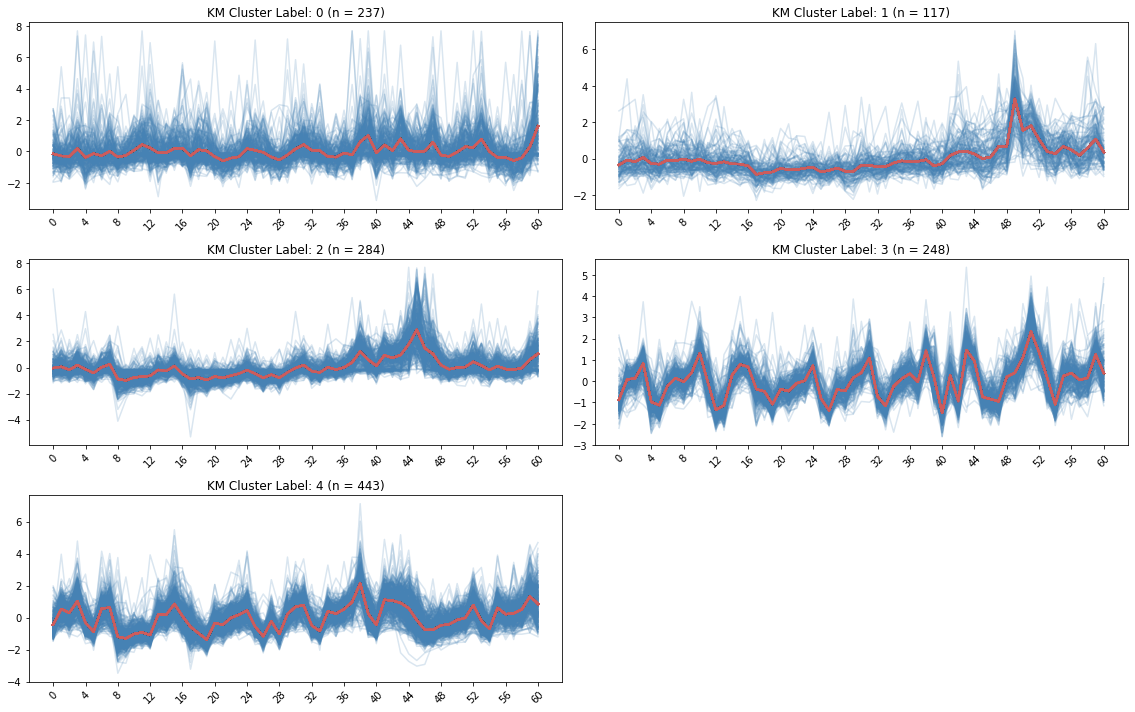

Last feature: active_count


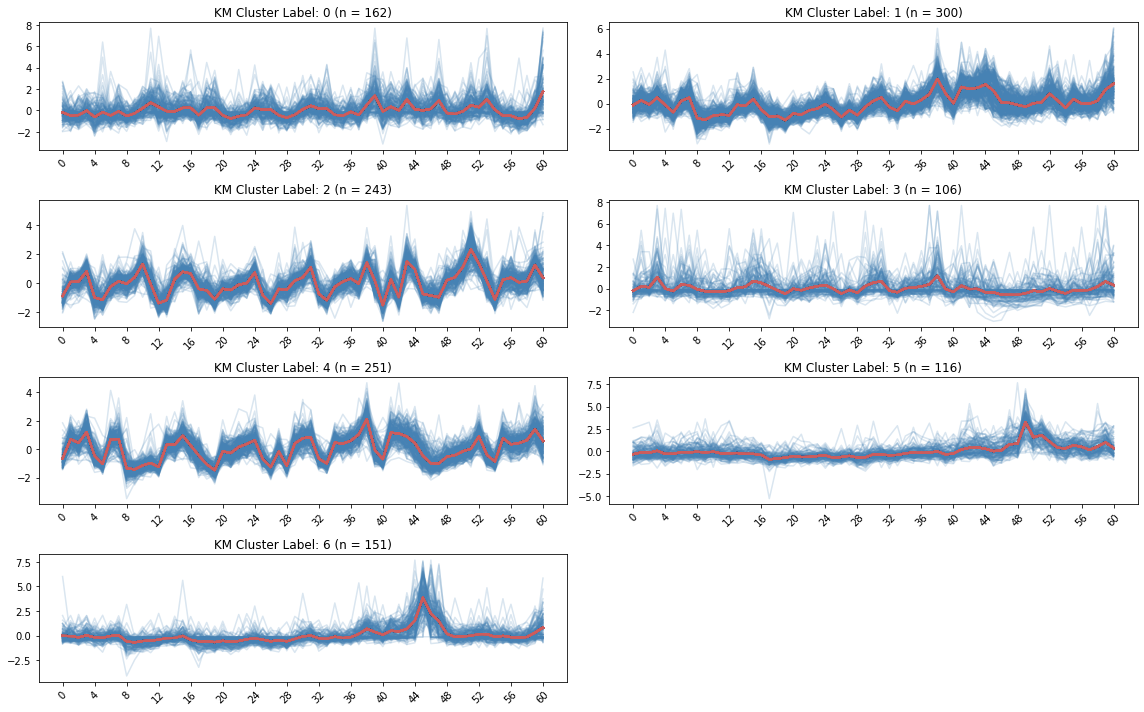

Last feature: active_count


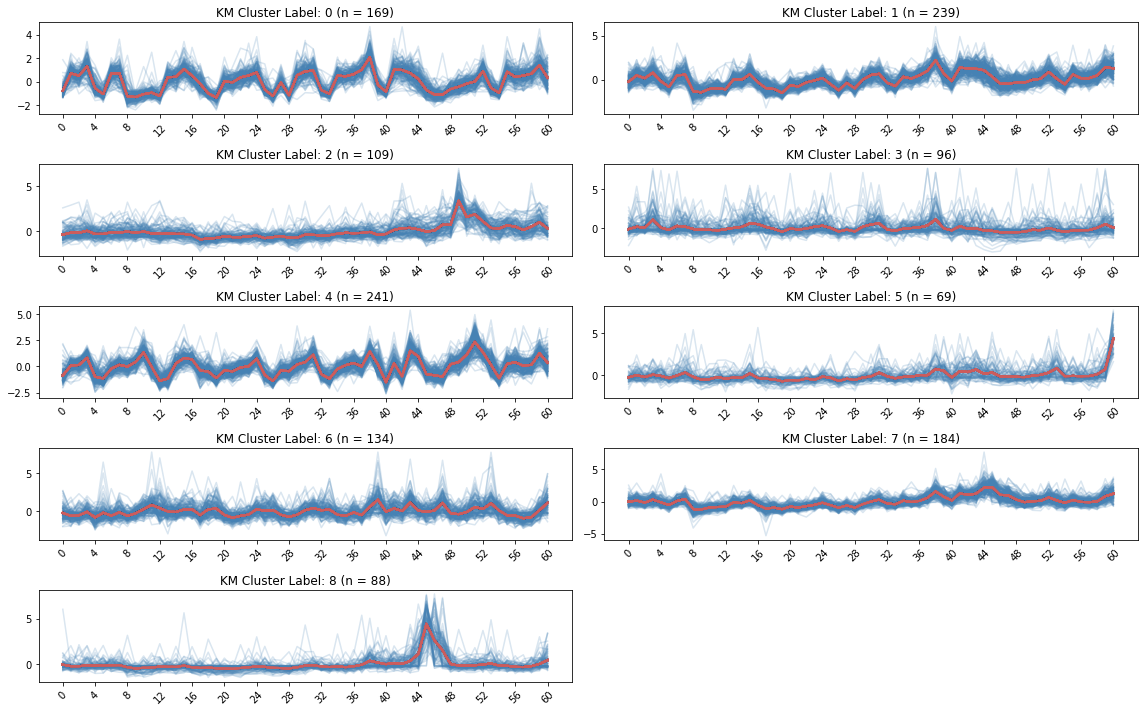

In [49]:
n_timesteps = 61
n_features = 62
plotKM(taz_daily, n_timesteps, n_features, 5)
plotKM(taz_daily, n_timesteps, n_features, 7)
plotKM(taz_daily, n_timesteps, n_features, 9)

In [58]:
x, y = zip(*[(latlon[1], latlon[0]) for latlon in taz_daily.index.map(geohash.decode)])

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


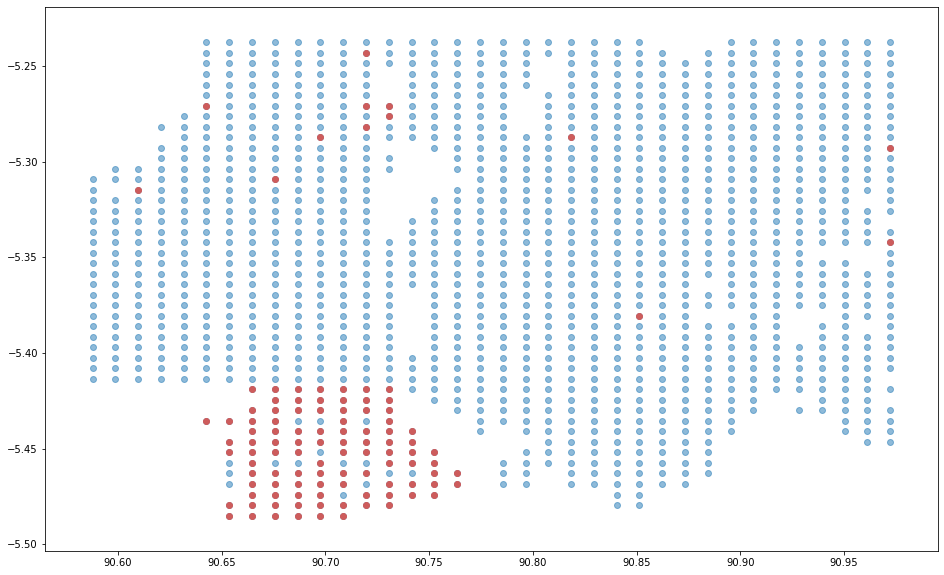

In [68]:
weird = taz_daily[taz_daily['label_km9'] == 2]
weird['x'], weird['y'] = zip(*[(latlon[1], latlon[0]) for latlon in weird.index.map(geohash.decode)])
plt.figure(figsize=(16,10))
plt.scatter(x, y, alpha=0.5)
plt.scatter(weird['x'], weird['y'], c='indianred')

Last feature: active_count


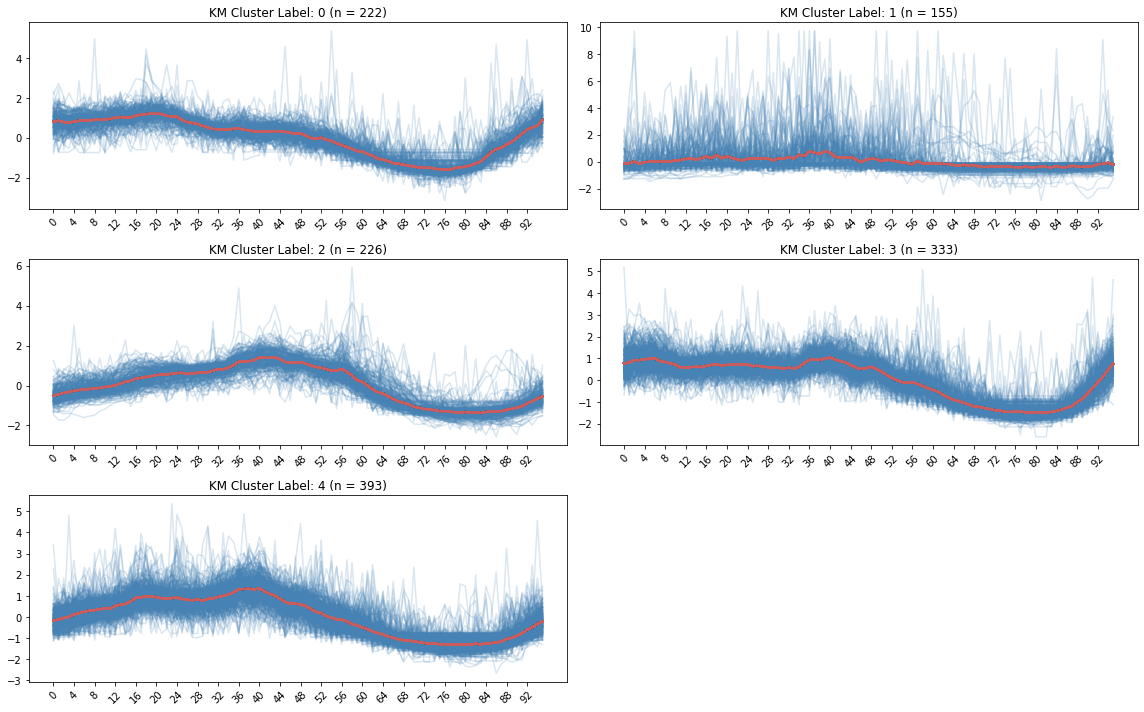

Last feature: active_count


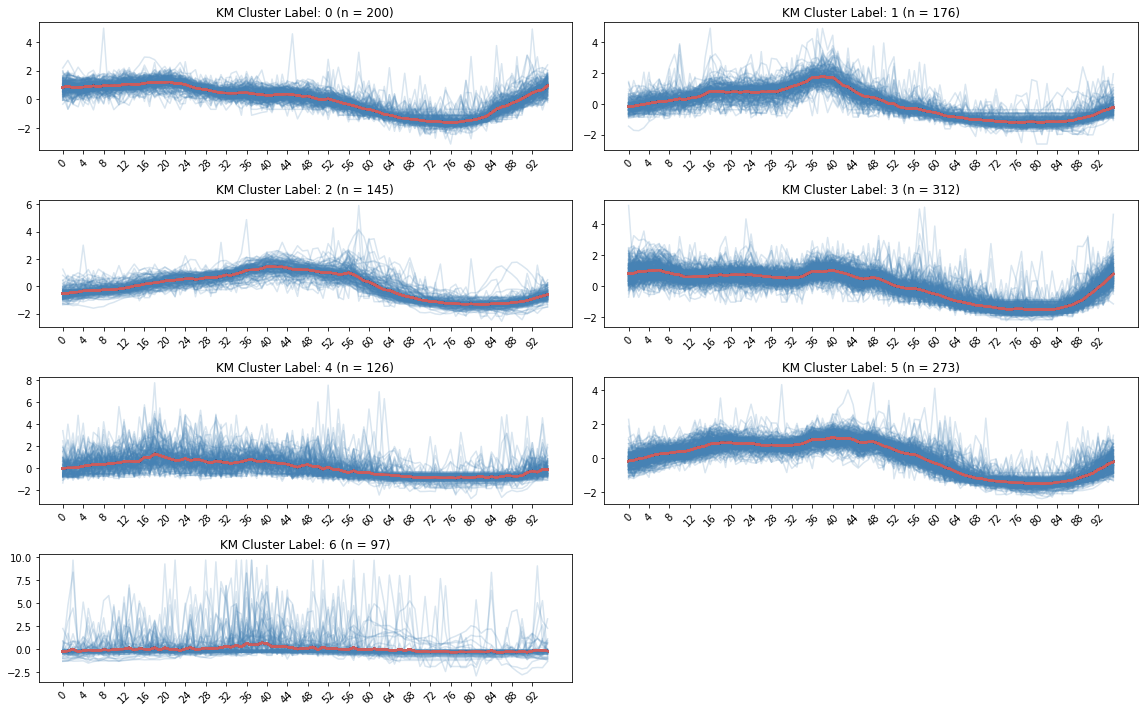

Last feature: active_count


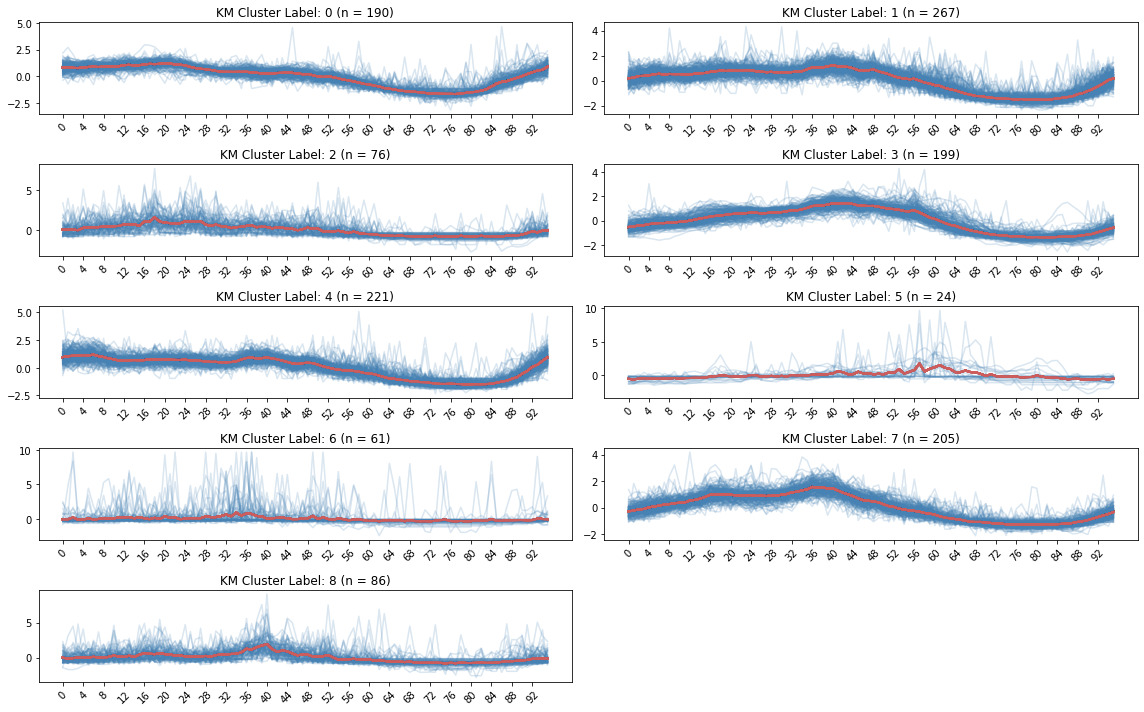

In [50]:
n_timesteps = 96
n_features = 97
plotKM(taz_quarterly, n_timesteps, n_features, 5)
plotKM(taz_quarterly, n_timesteps, n_features, 7)
plotKM(taz_quarterly, n_timesteps, n_features, 9)

# cluster regions
# cluster time series
- those that remain constant throughout the week
- those that has different am/pm demands

# 2. Spatial Patterns

In [52]:
import geohash
data['x'], data['y'] = zip(*[(latlon[1], latlon[0]) for latlon in data['geohash6'].map(geohash.decode)])

In [154]:
gdf_taz = gdf[['geohash6', 'geometry']].drop_duplicates(subset=['geohash6'], keep='first')
assert len(gdf_taz) == 1329
gdf_taz = gdf_taz.merge(taz_daily.reset_index()[['geohash6', 'label_km5', 'label_km7', 'label_km9']], how='left', on='geohash6')
gdf_taz['lon'] = gdf_taz['geometry'].apply(lambda p: (p.x))
gdf_taz['lat'] = gdf_taz['geometry'].apply(lambda p: (p.y))
gdf_taz.head(1)

,geohash6,geometry,label_km5,label_km7,label_km9,lon,lat
0,qp03wc,POINT (90.6536865234375 -5.35308837890625),2,2,1,90.653687,-5.353088


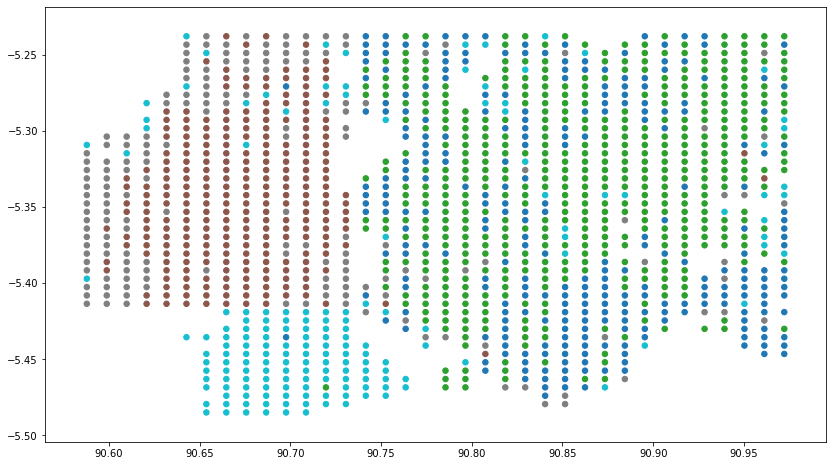

In [149]:
plt.figure(figsize=(14, 8))
plt.scatter(gdf_taz['lon'], gdf_taz['lat'], c=gdf_taz['label_km5'], cmap='tab10', alpha=1, s=30)

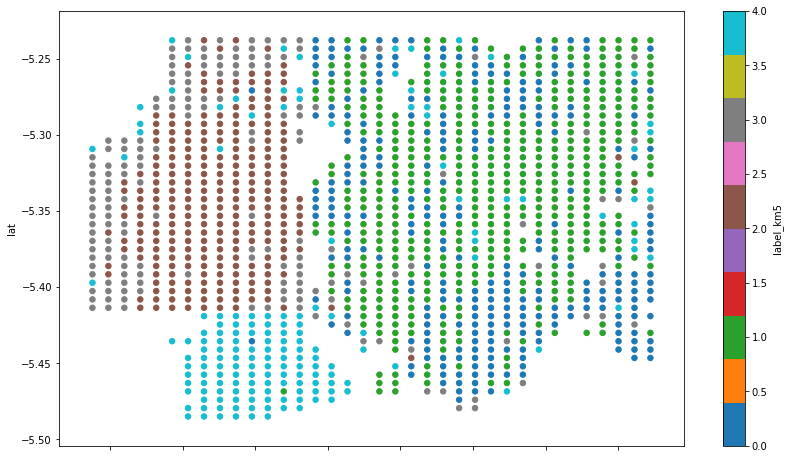

In [159]:
pd.DataFrame(gdf_taz).plot.scatter('lon', 'lat', c='label_km5', cmap='tab10', alpha=1, s=30, figsize=(14, 8))

In [ ]:
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib

carat = [5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30]
price = [100, 100, 200, 200, 300, 300, 400, 400, 500, 500, 600, 600]
color =['D', 'D', 'D', 'E', 'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G',]
df = pd.DataFrame(dict(carat=carat, price=price, color=color))

fig, ax = plt.subplots()
colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}
ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))
plt.show()

import seaborn as sns
sns.lmplot('carat', 'price', data=df, hue='color', fit_reg=False)
plt.show()

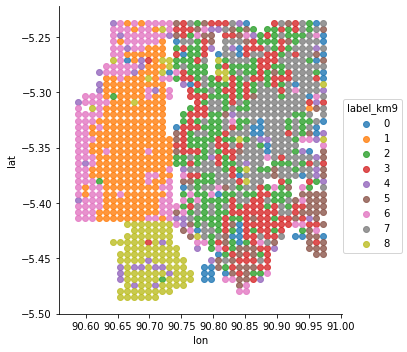

In [146]:
import seaborn as sns
sns.lmplot('lon', 'lat', data=gdf_taz, hue='label_km9', fit_reg=False)
plt.show()

In [ ]:
# dealing with rare demanding areas
unstable = taz_quarterly[taz_quarterly['label_km9'] == 2]
unstable_len = [len(data[data['geohash6'] == g]) for g in unstable.index]
unstable_len

In [196]:
data.to_csv('data_processed.csv', index=None)

In [200]:
output = data.sample(100000)
output.to_csv('output.csv', index=None)

# 9. Notes

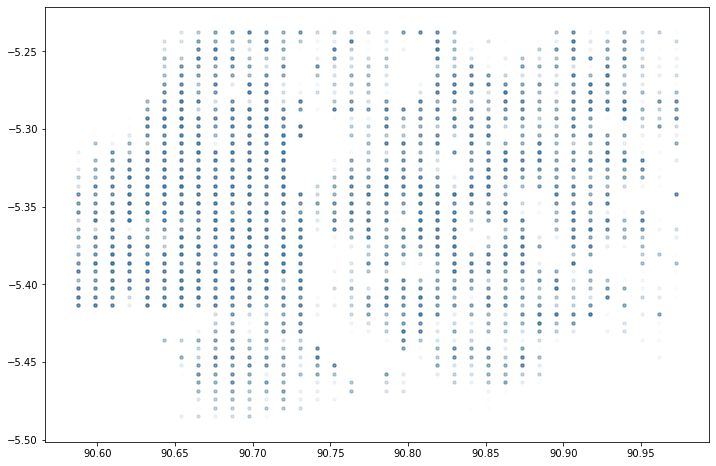

In [58]:
# TODO: slow
from shapely.geometry import Point
geom = [Point(latlon[1], latlon[0]) for latlon in data['geohash6'].apply(geohash.decode)]
gdf = gpd.GeoDataFrame(data, geometry=geom)
gdf.sample(50000).plot(figsize=(14, 8), alpha=0.01, markersize=10)

In [326]:
%%timeit
x, y = zip(*[(latlon[1], latlon[0]) for latlon in data['geohash6'][:1000].map(geohash.decode)])

2.26 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [327]:
%%timeit
geom = [Point(latlon[1], latlon[0]) for latlon in data['geohash6'][:1000].apply(geohash.decode)]

17.4 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
tmp = pd.to_datetime(data['time'][:10000].astype(str) + ' ' + data['date'][:10000].astype(str))

1.36 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
tmp = data[:10000].apply(lambda x: pd.datetime.combine(x['date'], x['time']), 1)

430 ms ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
